In [ ]:
import pandas as pd
import numpy as np
import researchpy as rp
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import joblib,os
import shap

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score,recall_score,f1_score, accuracy_score, roc_curve, roc_auc_score,confusion_matrix, precision_recall_curve

In [2]:
"""
This function takes a df[either comes from raw csv file or preprocessed df(such as sub df that output from this function)]
as input, then saperate feature and target. The output format is array 
"""

def raw_df_to_classifier_input_data(df):
    
    # Remove columns that all 0
    df = df.loc[:, (df != 0).any(axis=0)]
    
    # If it's a raw df comes from raw csv
    if 'DECOY' in df.columns.tolist():
        # Use TARGET instead of DECOY 
        df['TARGET'] = df['DECOY'].apply(lambda x: np.abs(x-1))
        # Calculate RT_LENGTH
        df.loc[:, 'RT_LENGTH'] = df.loc[:, 'RT_END'] - df.loc[:, 'RT_START']
    
    # Only keep sub socres RT_LENGTH and TARGET
    cols = [x for x in df.columns.tolist() if x[:4] == 'VAR_']
    cols.append('RT_LENGTH')
    # 
    feature_cols = cols.copy()
    cols.append('TARGET')
    
    # df that filtered columns that all 0,keep all interested features and label
    df = df[cols]
    
    feature = df[feature_cols]
    feature_name = feature.columns.tolist()
    feature = feature.values
    
    # Lable with feature index
    target = df[['TARGET']]
    target_name = target.columns.tolist
    target = target.values
    target = target[:, 0]
    
    
    print('\nARRAY DESCRIPTION:')
    print("Features' shape: "+str(feature.shape))
    print("Target's shape: "+str(target.shape))
    unique, counts = np.unique(target, return_counts=True)
    print('TARGET summary: '+str(dict(zip(unique, counts))))
    
    return df, feature, target, feature_name, target_name

In [3]:
# A faster way to get decision_scores
def calculate_probability(input_classifier, x, y=None):
    from cleanlab.latent_estimation import estimate_confident_joint_and_cv_pred_proba

    #proba = input_classifier.predict_proba(x)[:, 1]
    # decision_scores = np.log(proba / (1 - proba))
    try:
        y_scores = input_classifier.decision_function(x)
    # excute if there is error
    except:
        confident_joint, y_scores = estimate_confident_joint_and_cv_pred_proba(
            X=x, 
            s=y,
            clf=input_classifier,
            cv_n_folds= 2)

        y_scores = y_scores[:,1]
    return y_scores

# Plot one roc curve when giving fpr and tpr
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel = 'False Positive Rate'
    plt.ylabel = 'True Positive Rate'
    plt.legend()

# Pringt precision/recall/f1/confusion matrix
def print_scores(y_true, y_predicted):
    print('Accuracy: ', accuracy_score(y_true, y_predicted), end='\n')
    print('Precision: ',precision_score(y_true, y_predicted), end='\n')
    print('Recall: ', recall_score(y_true, y_predicted), end='\n')
    print('f1: ', f1_score(y_true, y_predicted), end='\n')
    print('Confusion Matrix:\n')
    conf_mtrix = pd.DataFrame(confusion_matrix(y_true, y_predicted), columns=['Predicted Negtive', 'Predicted Positive'], index=['Actual Negtive', 'Actual Postive'])
    print(conf_mtrix.to_string())

# 1. Load input csv and feature distribution

In [4]:
data = pd.read_csv('/srv/data1/li7186lu/data/classifier/training_data/0325_merged_AAS_P2009_167_to_253.csv', sep=',')

## Separate features and targets

In [5]:
data_df, feature, target, feature_name, target_name = raw_df_to_classifier_input_data(data)


ARRAY DESCRIPTION:
Features' shape: (42531675, 12)
Target's shape: (42531675,)
TARGET summary: {0: 15021515, 1: 27510160}


## Explore features

In [6]:
feature_name

['VAR_INTENSITY_SCORE',
 'VAR_INTENSITY_RATIO_SCORE',
 'VAR_LOG_INTENSITY',
 'VAR_XCORR_COELUTION',
 'VAR_XCORR_SHAPE',
 'VAR_LOG_SN_SCORE',
 'VAR_MASSDEV_SCORE',
 'VAR_MI_SCORE',
 'VAR_MI_RATIO_SCORE',
 'VAR_ISOTOPE_CORRELATION_SCORE',
 'VAR_ISOTOPE_OVERLAP_SCORE',
 'RT_LENGTH']

In [7]:
sub_index_0 = data_df[data_df['TARGET']==0].index.tolist()
np.random.shuffle(sub_index_0)
sub_data_0 = data_df[data_df['TARGET']==0].loc[sub_index_0[:2000], :]

sub_index_1 = data_df[data_df['TARGET']==1].index.tolist()
np.random.shuffle(sub_index_1)
sub_data_1 = data_df[data_df['TARGET']==1].loc[sub_index_1[:2000], :]

sub_data = pd.concat((sub_data_0, sub_data_1), join='inner')

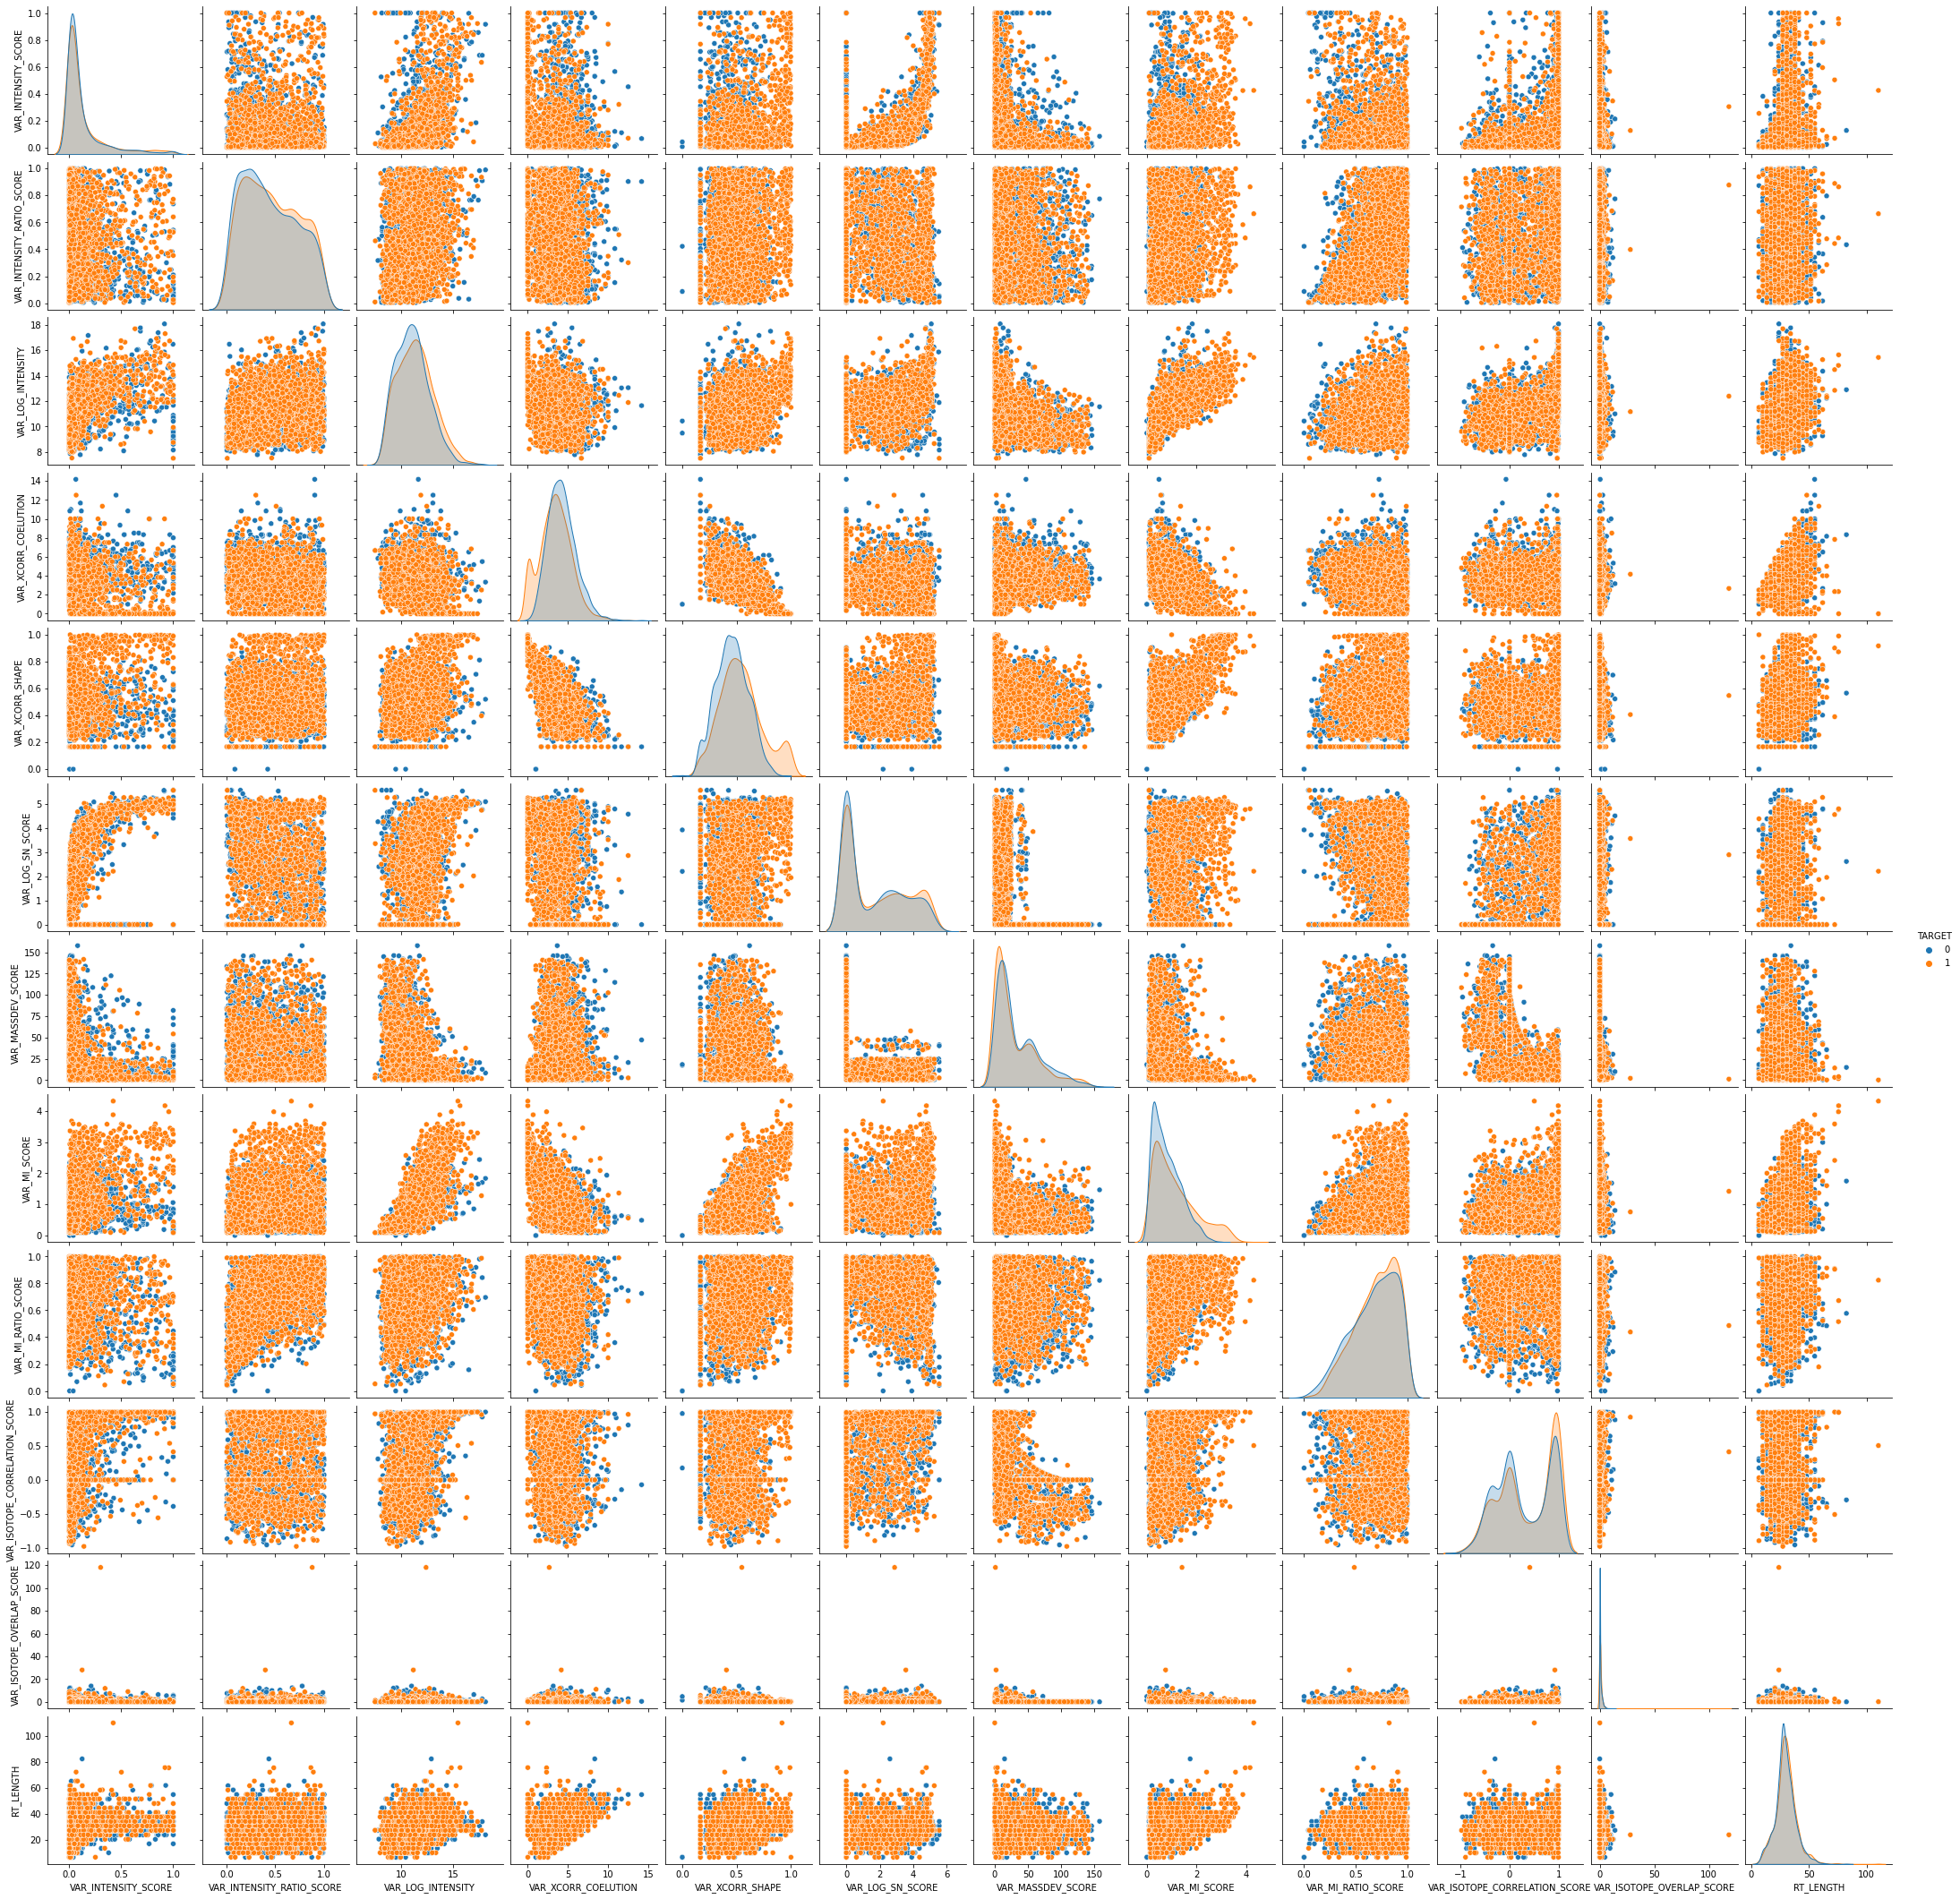

In [8]:
import seaborn as sns
sns.pairplot(sub_data, hue='TARGET')
#plt.savefig(f'/srv/data1/li7186lu/data/yeast_benchmark/plots/features_distribution.jpg')

## Hold-out: split training data and test data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state=42, shuffle=True, test_size=0.2)

In [10]:
Counter(y_train)

Counter({1: 22009046, 0: 12016294})

## Reload classifiers to get precisions on test set

sgd_classifier = joblib.load('/srv/data1/li7186lu/data/classifier/previous_models/initial.pkl')
standardscaler = joblib.load('/srv/data1/li7186lu/data/classifier/previous_models/standardscaler.pkl')
precision_90_classifier = joblib.load('/srv/data1/li7186lu/data/classifier/previous_models/precision_90.pkl')
standardscaler_90 = joblib.load('/srv/data1/li7186lu/data/classifier/previous_models/standardscaler_90.pkl')
manually_filtered_classifier = joblib.load('/srv/data1/li7186lu/data/classifier/previous_models/gscore.pkl')
standardscaler_qvalue = joblib.load('/srv/data1/li7186lu/data/classifier/previous_models/standardscaler_gscore.pkl')
lnl = joblib.load('/srv/data1/li7186lu/data/classifier/previous_models/lnl.pkl')

# 2. Build SGD Classifier

## 2.1 SGD classifier without removing any indices

### Standard Scale

In [11]:
standardscaler = StandardScaler()
standardscaler.fit(X_train)
X_train_standard = standardscaler.transform(X_train)
X_test_standard = standardscaler.transform(X_test)

In [12]:
X_train.shape

(34025340, 12)

In [13]:
X_test.shape

(8506335, 12)

In [14]:
Counter(y_train)

Counter({1: 22009046, 0: 12016294})

In [15]:
Counter(y_test)

Counter({0: 3005221, 1: 5501114})

### Model fit

In [16]:
sgd_classifier = SGDClassifier(loss='log', random_state=42)
sgd_classifier.fit(X_train_standard, y_train)

SGDClassifier(loss='log')

### Prediction and evaluation

In [17]:
y_test_pred_initial = sgd_classifier.predict(X_test_standard)

print_scores(y_test, y_test_pred_initial)

Accuracy:  0.6447190241155563
Precision:  0.66221027767879
Recall:  0.9198331465226861
f1:  0.7700458205619648
Confusion Matrix:

                Predicted Negtive  Predicted Positive
Actual Negtive             424089             2581132
Actual Postive             441007             5060107


ROC AUC: 0.6361122373984501


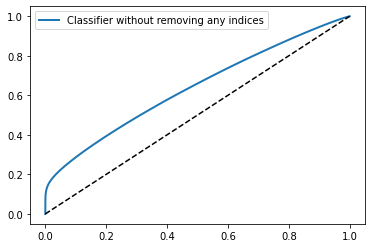

In [18]:
y_scores_initial = calculate_probability(sgd_classifier,x=X_test_standard)
fpr, tpr, thresholds = roc_curve(y_test, y_scores_initial)

plot_roc_curve(fpr, tpr, label='Classifier without removing any indices')
roc_auc = roc_auc_score(y_test, y_scores_initial)
print('ROC AUC:', roc_auc, end='\n')

## 2.2 Improving precision

### 2.2.1 Use the precision/recall trade-off on all dataset

In [19]:
features_standard = standardscaler.transform(feature)

In [20]:
initial_train_scores = calculate_probability(sgd_classifier,x=features_standard)

In [21]:
precisions, recalls, thresholds = precision_recall_curve(target, initial_train_scores)

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b-', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend()

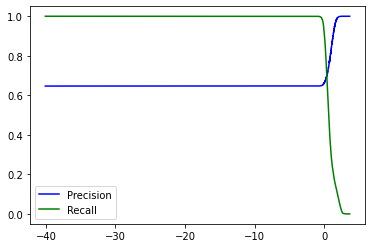

In [23]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [24]:
# Find the threshold that Precision = 0.9
tt = {'Precision' : precisions[:-1].tolist(), 'Recall':recalls[:-1].tolist(), 'Threshold':thresholds.tolist()}
tt = pd.DataFrame(tt)
tt[tt['Precision'] == 0.90]

Empty DataFrame
Columns: [Precision, Recall, Threshold]
Index: []

### Remove noisy labels

In [25]:
# Get the y_score threshold
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [26]:
feature_90_precision = feature[initial_train_scores >= threshold_90_precision]
target_90_precision = target[initial_train_scores >= threshold_90_precision]

In [27]:
target_90_precision.shape

(6508655,)

In [28]:
Counter(target_90_precision)

Counter({1: 5857790, 0: 650865})

### Model fit

In [29]:
standardscaler_90 = StandardScaler()
standardscaler_90.fit(feature_90_precision)
X_train_90_standard = standardscaler_90.transform(feature_90_precision)
X_test_90_standard = standardscaler_90.transform(X_test)

In [30]:
precision_90_classifier = SGDClassifier(loss='log', class_weight="balanced")
precision_90_classifier.fit(X_train_90_standard, target_90_precision)

SGDClassifier(class_weight='balanced', loss='log')

### Prediction and evaluation

In [31]:
y_test_pred_precision_90 = precision_90_classifier.predict(X_test_90_standard)
print_scores(y_test, y_test_pred_precision_90)

Accuracy:  0.4480440753861681
Precision:  0.9776611203694265
Recall:  0.14994035753485566
f1:  0.2600047282814273
Confusion Matrix:

                Predicted Negtive  Predicted Positive
Actual Negtive            2986374               18847
Actual Postive            4676275              824839


ROC AUC: 0.6302369090806678


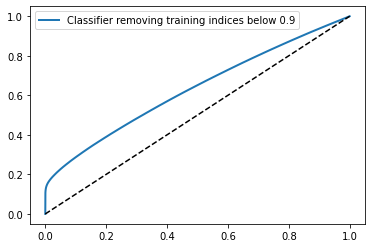

In [32]:
y_scores_precision_90 = calculate_probability(precision_90_classifier,x=X_test_90_standard)
fpr, tpr, thresholds = roc_curve(y_test, y_scores_precision_90)

plot_roc_curve(fpr, tpr, label='Classifier removing training indices below 0.9')
roc_auc = roc_auc_score(y_test, y_scores_precision_90)
print('ROC AUC:', roc_auc, end='\n')

### 2.2.1* Use the precision/recall trade-off on training set

In [90]:
initial_train_scores = calculate_probability(sgd_classifier,x=X_train_standard)

In [92]:
precisions, recalls, thresholds = precision_recall_curve(y_train, initial_train_scores)

In [93]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b-', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend()

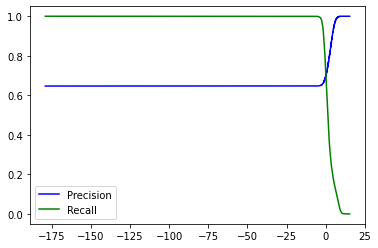

In [94]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [95]:
# Find the threshold that Precision = 0.9
tt = {'Precision' : precisions[:-1].tolist(), 'Recall':recalls[:-1].tolist(), 'Threshold':thresholds.tolist()}
tt = pd.DataFrame(tt)
tt[tt['Precision'] == 0.90]

Empty DataFrame
Columns: [Precision, Recall, Threshold]
Index: []

### Remove noisy labels

In [96]:
# Get the y_score threshold
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [98]:
feature_90_precision_plus = X_train[initial_train_scores >= threshold_90_precision]
target_90_precision_plus = y_train[initial_train_scores >= threshold_90_precision]

In [99]:
target_90_precision_plus.shape

(5141123,)

In [100]:
Counter(target_90_precision_plus)

Counter({1: 4627011, 0: 514112})

In [ ]:
4627011/514112

### Model fit

In [101]:
standardscaler_90_plus = StandardScaler()
standardscaler_90_plus.fit(feature_90_precision_plus)
X_train_90_standard_plus = standardscaler_90_plus.transform(feature_90_precision_plus)
X_test_90_standard_plus = standardscaler_90_plus.transform(X_test)

In [102]:
precision_90_classifier_plus = SGDClassifier(loss='log', class_weight="balanced")
precision_90_classifier_plus.fit(X_train_90_standard_plus, target_90_precision_plus)

SGDClassifier(class_weight='balanced', loss='log')

### Prediction and evaluation

In [103]:
y_test_pred_precision_90_plus = precision_90_classifier_plus.predict(X_test_90_standard_plus)
print_scores(y_test, y_test_pred_precision_90_plus)

Accuracy:  0.4486390437244712
Precision:  0.976512018951131
Recall:  0.15106794732848655
f1:  0.26165712527028273
Confusion Matrix:

                Predicted Negtive  Predicted Positive
Actual Negtive            2985232               19989
Actual Postive            4670072              831042


ROC AUC: 0.6297455275823858


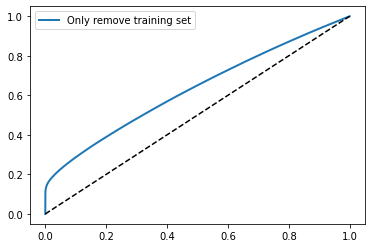

In [107]:
y_scores_precision_90_plus = calculate_probability(precision_90_classifier_plus,x=X_test_90_standard_plus)
fpr, tpr, thresholds = roc_curve(y_test, y_scores_precision_90_plus)

plot_roc_curve(fpr, tpr, label='Only remove training set')
roc_auc = roc_auc_score(y_test, y_scores_precision_90_plus)
print('ROC AUC:', roc_auc, end='\n')

In [108]:
joblib.dump(precision_90_classifier_plus,'/srv/data1/li7186lu/data/classifier/models/precision_plus.pkl')
joblib.dump(standardscaler_90_plus,'/srv/data1/li7186lu/data/classifier/models/standardscaler_90_plus.pkl')

['/srv/data1/li7186lu/data/classifier/models/standardscaler_90_plus.pkl']

### 2.2.2 qvalue cutoff

In [70]:
initial_scores = calculate_probability(sgd_classifier,x=features_standard)

In [71]:
#training_array = np.concatenate((X_train_standard, y_train.reshape(-1, 1), initial_train_scores.reshape(-1, 1)),axis=1)
data_array = np.concatenate((feature, target.reshape(-1, 1), initial_scores.reshape(-1, 1)),axis=1)

In [72]:
training_df_cols = feature_name.copy()
training_df_cols.append('TARGET')
training_df_cols.append('Initial_train_scores')
#training_df = pd.DataFrame(training_array, columns=training_df_cols)
data = pd.DataFrame(data_array, columns=training_df_cols)

[(-10.0, 10.0)]

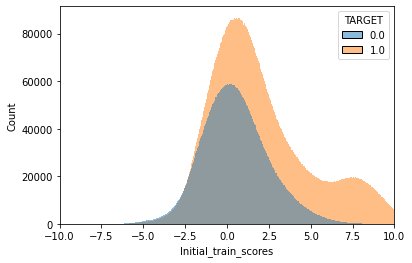

In [76]:
fig = sns.histplot(data=data, x="Initial_train_scores", hue="TARGET")
fig.set(xlim=(-10, 10))

In [77]:
train_data_array = np.concatenate((X_train, y_train.reshape(-1, 1)),axis=1)
training_cols = training_df_cols.copy()
training_cols.pop()      
#training_df = pd.DataFrame(training_array, columns=training_df_cols)
train_data = pd.DataFrame(train_data_array, columns=training_cols)

### Calculate qvalue to filter indices

In [78]:
from gscore.fdr import ScoreDistribution
score_distribution = ScoreDistribution()
score_distribution.fit(
    initial_scores.ravel(), # Decision function scores from the classifier
    target.ravel()# TARGET labels
)

q_values = score_distribution.calculate_q_values(
initial_scores
)

In [79]:
data['qvalue'] = q_values
filter_training_target = data[data['TARGET'] == 1]
# Only keep decoys in training set, not all
filter_training_decoy = train_data[train_data['TARGET'] == 0]
filter_training_target = filter_training_target[filter_training_target['qvalue'] < 0.01]
filter_training_df = pd.concat((filter_training_target, filter_training_decoy), join='outer')
filter_training_df = filter_training_df.drop(columns=['qvalue'])

In [80]:
feature_qcutoff = filter_training_df[feature_name].values
target_qcutoff = filter_training_df['TARGET'].values

In [81]:
Counter(target_qcutoff)

Counter({1.0: 2699272, 0.0: 12016294})

In [82]:
target_qcutoff.shape

(14715566,)

### Model fit

In [85]:
standardscaler_qvalue = StandardScaler()
standardscaler_qvalue.fit(feature_qcutoff)
X_train_qcutoff_standard = standardscaler_qvalue.transform(feature_qcutoff)
X_test_qcutoff_standard = standardscaler_qvalue.transform(X_test)

In [86]:
qvalue_cutoff_classifier = SGDClassifier(loss='log', class_weight="balanced")
qvalue_cutoff_classifier.fit(X_train_qcutoff_standard, target_qcutoff)

SGDClassifier(class_weight='balanced', loss='log')

In [87]:
y_test_pre_qcutoff = qvalue_cutoff_classifier.predict(X_test_qcutoff_standard)
print_scores(y_test, y_test_pre_qcutoff)

Accuracy:  0.4389722483302151
Precision:  0.9794831646952014
Recall:  0.13532113677338808
f1:  0.2377902114700172
Confusion Matrix:

                Predicted Negtive  Predicted Positive
Actual Negtive            2989628               15593
Actual Postive            4756697              744417


ROC AUC: 0.6356387010048811


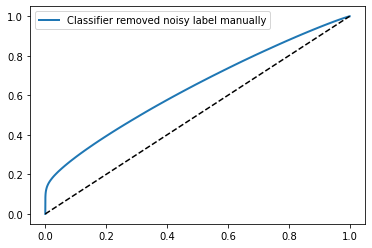

In [88]:
y_scores_qvalue_cutoff= calculate_probability(qvalue_cutoff_classifier,x=X_test_qcutoff_standard)
fpr, tpr, thresholds = roc_curve(y_test, y_scores_qvalue_cutoff)
plot_roc_curve(fpr, tpr, label='Classifier removed noisy label manually')
roc_auc = roc_auc_score(y_test, y_scores_qvalue_cutoff)
print('ROC AUC:', roc_auc, end='\n')

In [89]:
joblib.dump(qvalue_cutoff_classifier,'/srv/data1/li7186lu/data/classifier/models/qcutoff.pkl')
joblib.dump(standardscaler_qvalue,'/srv/data1/li7186lu/data/classifier/models/standardscaler_qvalue.pkl')

['/srv/data1/li7186lu/data/classifier/models/standardscaler_qvalue.pkl']

### 2.2.3 Use cleanlab to improve precision

In [47]:
from cleanlab.classification import LearningWithNoisyLabels
lnl = LearningWithNoisyLabels(clf=sgd_classifier)
lnl.fit(X_train_standard, y_train)

SGDClassifier(loss='log')

In [48]:
y_predicted_lnl = lnl.predict(X_test_standard)
print_scores(y_test, y_predicted_lnl)

Accuracy:  0.6167593916769091
Precision:  0.6962218335194449
Recall:  0.7227512463839142
f1:  0.7092385402690564
Confusion Matrix:

                Predicted Negtive  Predicted Positive
Actual Negtive            1270425             1734796
Actual Postive            1525177             3975937


ROC AUC: 0.636965019601999


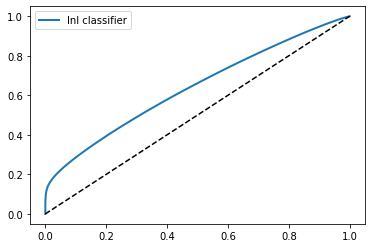

In [49]:
y_scores_lnl = calculate_probability(lnl,x=X_test_standard, y=y_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores_lnl)
plot_roc_curve(fpr, tpr, label='lnl classifier')
roc_auc_lnl = roc_auc_score(y_test, y_scores_lnl)
print('ROC AUC:', roc_auc_lnl, end='\n')

# 3.Comparasion of 4 classifiers

## 3.1 Precision

In [124]:
comparasion_df = {
    'Classifiers': ['initial', 'Presion_90', 'Presion_90_plus', 'qvalue_cutoff', 'lnl'],
    'y_test_predicted': [y_test_pred_initial, y_test_pred_precision_90,y_test_pred_precision_90_plus, y_test_pre_qcutoff, y_predicted_lnl]
}

comparasion_df = pd.DataFrame(comparasion_df)
comparasion_df['Precision'] = comparasion_df['y_test_predicted'].apply(lambda x: precision_score(y_test, x))
print(comparasion_df[['Classifiers', 'Precision']].to_string(index=False))

    Classifiers  Precision
        initial   0.662210
     Presion_90   0.977661
Presion_90_plus   0.976512
  qvalue_cutoff   0.979483
            lnl   0.696222


# *Save models

In [51]:
import joblib
import os
if not os.path.exists("/srv/data1/li7186lu/data/classifier/models/"):
    os.mkdir("/srv/data1/li7186lu/data/classifier/models")

joblib.dump(sgd_classifier,'/srv/data1/li7186lu/data/classifier/models/initial.pkl')
joblib.dump(precision_90_classifier,'/srv/data1/li7186lu/data/classifier/models/precision_90.pkl')
joblib.dump(qvalue_cutoff_classifier,'/srv/data1/li7186lu/data/classifier/models/qcutoff.pkl')
#joblib.dump(lnl,'/srv/data1/li7186lu/scripts/data/model/lnl.pkl')
joblib.dump(standardscaler,'/srv/data1/li7186lu/data/classifier/models/standardscaler.pkl')
joblib.dump(standardscaler_90,'/srv/data1/li7186lu/data/classifier/models/standardscaler_90.pkl')
joblib.dump(standardscaler_qvalue,'/srv/data1/li7186lu/data/classifier/models/standardscaler_qvalue.pkl')
joblib.dump(lnl,'/srv/data1/li7186lu/data/classifier/models/lnl.pkl')

['/srv/data1/li7186lu/data/classifier/models/lnl.pkl']

# Explain every classifier using shapley value

## Initial

In [52]:
explainer = shap.LinearExplainer(sgd_classifier, X_train_standard)
shap_values_initial = explainer(X_test_standard)

Linear explainer: 8506336it [01:44, 71837.78it/s]


In [53]:
X_test[0,:]

array([ 0.07349144,  0.41078873, 13.06240273,  2.16666667,  0.62744434,
        1.41704258, 18.44123066,  1.06827341,  0.90321528,  0.31786705,
        0.        , 17.22460938])

In [54]:
y_test[0]

0

In [55]:
X_test_standard[0,:]

array([-0.29685343, -0.1703721 ,  1.04818071, -0.77546688,  0.61531729,
       -0.1628723 , -0.40500074,  0.03847908,  1.00821562, -0.02351364,
       -0.32420014, -1.43324939])

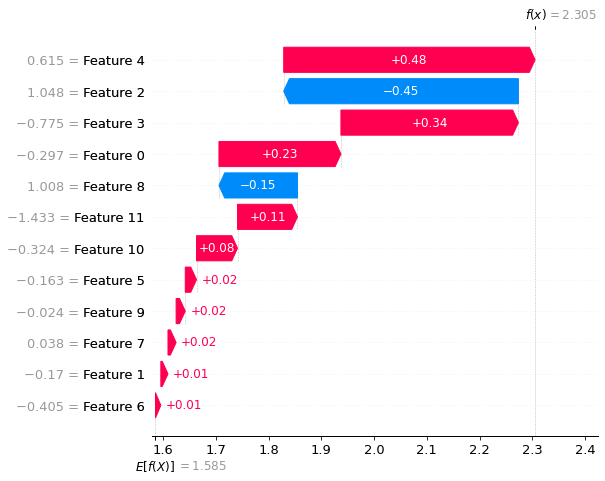

In [56]:
shap.plots.waterfall(shap_values_initial[0], max_display=20)

TypeError: 'str' object is not callable

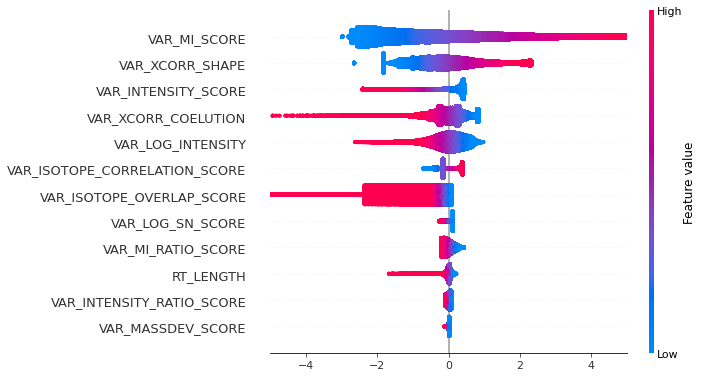

In [114]:
plt.xlim(-5,5)
shap.summary_plot(shap_values_initial, X_test_standard, feature_names=feature_name)

## Precision

In [58]:
explainer = shap.LinearExplainer(precision_90_classifier, X_train_90_standard)
shap_values_precision = explainer(X_test_90_standard)

Linear explainer: 8506336it [01:47, 73642.07it/s]


In [59]:
X_test_90_standard[0,:]

array([-0.74292438, -0.56884402,  0.09068278,  0.75880633, -1.13280846,
       -0.95866194,  0.58299736, -2.4332535 ,  0.78177901, -1.03399678,
       -0.45420867, -1.88661478])

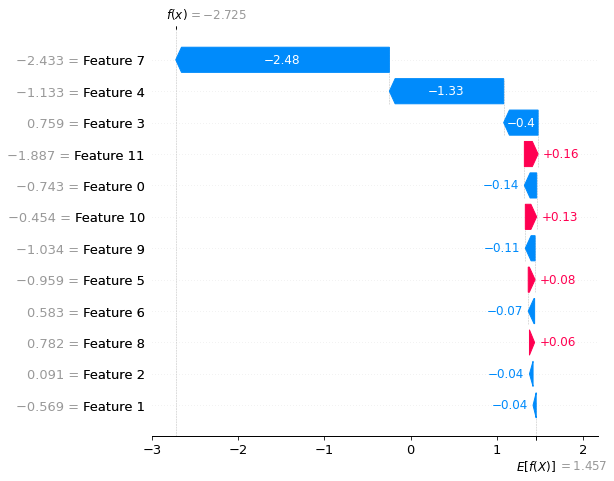

In [60]:
shap.plots.waterfall(shap_values_precision[0], max_display=20)

TypeError: 'str' object is not callable

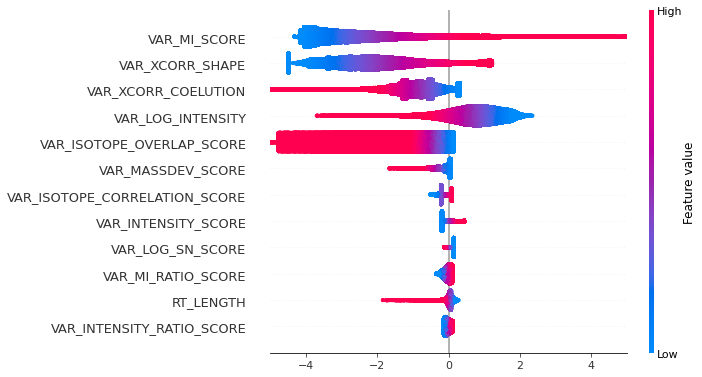

In [115]:
plt.xlim(-5,5)
shap.summary_plot(shap_values_precision, X_test_90_standard, feature_names=feature_name)

## Precision_plus

In [116]:
explainer = shap.LinearExplainer(precision_90_classifier_plus, X_test_90_standard_plus)
shap_values_precision_plus = explainer(X_test_90_standard_plus)

Linear explainer: 8506336it [01:33, 79657.14it/s]


In [117]:
X_test_90_standard_plus[0,:]

array([-0.74292438, -0.56884402,  0.09068278,  0.75880633, -1.13280846,
       -0.95866194,  0.58299736, -2.4332535 ,  0.78177901, -1.03399678,
       -0.45420867, -1.88661478])

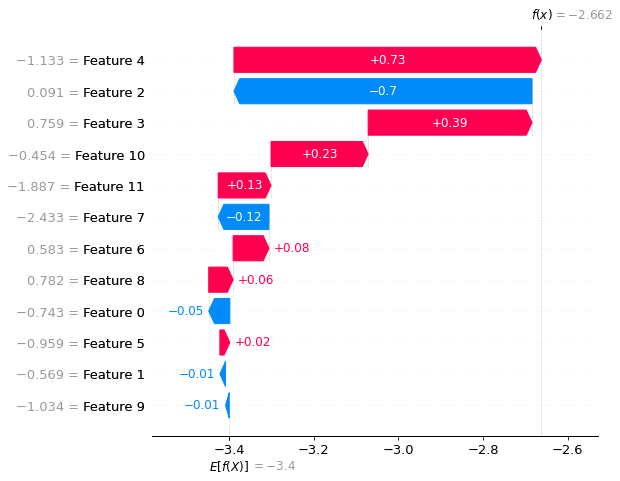

In [118]:
shap.plots.waterfall(shap_values_precision_plus[0], max_display=20)

TypeError: 'str' object is not callable

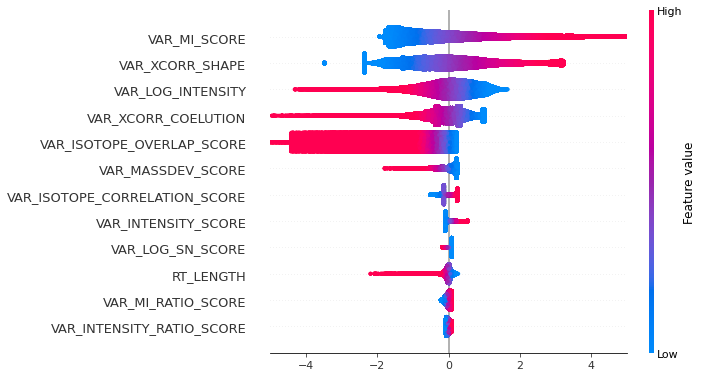

In [119]:
plt.xlim(-5,5)
shap.summary_plot(shap_values_precision_plus, X_test_90_standard_plus, feature_names=feature_name)

## Qvalue cutoff

In [120]:
explainer = shap.LinearExplainer(precision_90_classifier, X_train_qcutoff_standard)
shap_values_qcutoff = explainer(X_test_qcutoff_standard)

Linear explainer: 8506336it [01:39, 81640.99it/s]


In [121]:
X_test_qcutoff_standard[0,:]

array([-0.40288745, -0.21659912,  0.87562379, -0.60513048,  0.39937711,
       -0.28496405, -0.33498057, -0.12732251,  0.98111801, -0.12158166,
       -0.26654124, -1.43618421])

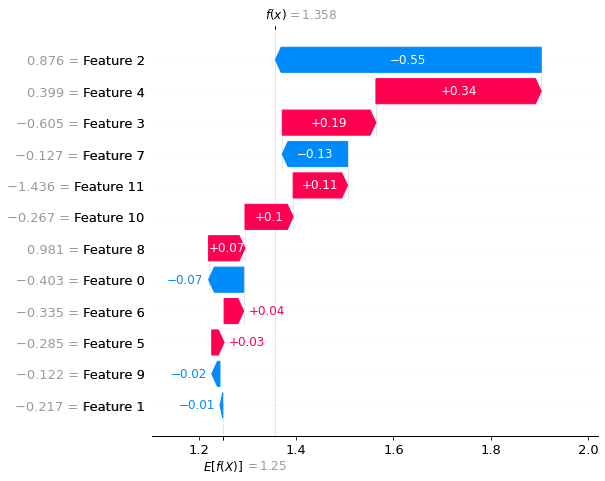

In [122]:
shap.plots.waterfall(shap_values_qcutoff[0], max_display=20)

TypeError: 'str' object is not callable

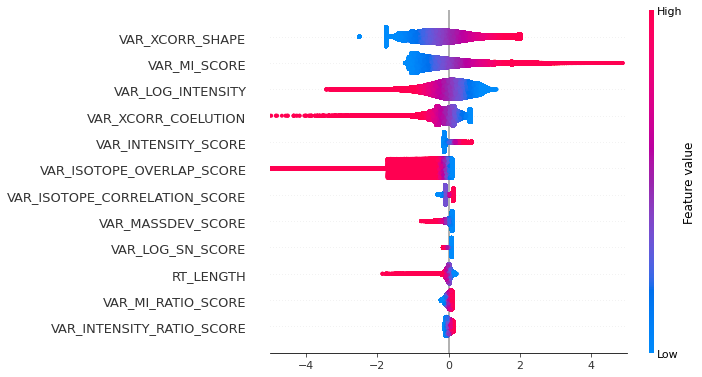

In [123]:
plt.xlim(-5, 5)
shap.summary_plot(shap_values_qcutoff, X_test_qcutoff_standard, feature_names=feature_name)

In [125]:
feature_name

['VAR_INTENSITY_SCORE',
 'VAR_INTENSITY_RATIO_SCORE',
 'VAR_LOG_INTENSITY',
 'VAR_XCORR_COELUTION',
 'VAR_XCORR_SHAPE',
 'VAR_LOG_SN_SCORE',
 'VAR_MASSDEV_SCORE',
 'VAR_MI_SCORE',
 'VAR_MI_RATIO_SCORE',
 'VAR_ISOTOPE_CORRELATION_SCORE',
 'VAR_ISOTOPE_OVERLAP_SCORE',
 'RT_LENGTH']